## 문제 6

**Kaggle 형** train_prob.csv로 문제 target을 예측하는 모델을 만들고, 

test_prob.csv에 대한 target 예측하여 다음과 같은 형식의 answer6.csv를 만들어라.

id, target

0, 6.9

5, 7.8

...


**평가지표**

$RMSE(Y, \hat{Y}) = \sqrt{\frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2}$


In [1]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1


In [2]:
import xgboost as xgb
xgb.__version__

'0.80'

In [3]:
df_train = pd.read_csv('train_prob.csv', index_col='id')
df_test = pd.read_csv('test_prob.csv', index_col='id')

In [4]:
# 전처리를 합니다.
repl_list = [
    ('cat3', {'B': 'C'}, [83634, 147361, 9005]),
    ('cat4', {'A':'B', 'D': 'B'}, [239397, 603]),
    ('cat6', {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'}, [234203, 5145, 652]),
    ('cat7', {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'}, [4606, 19784, 214027, 1583]),
    ('cat8', {'B': 'G', 'F': 'E'}, [30338, 96743, 2953, 76085, 33881]),
    ('cat9', {'C': 'H', 'D': 'B', 'E': 'L'}, [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968])
]

for c, d, cnts in repl_list:
    s_tmp = df_train[c].replace(d)
    if s_tmp.nunique() != len(cnts):
        print("cnt not same")
        break
    print(c, d, cnts, np.sum(s_tmp.value_counts().sort_index() != cnts))
    if np.sum(s_tmp.value_counts().sort_index() != cnts) != 0:
        break
    df_train[c] = s_tmp
    df_test[c] = df_test[c].replace(d)

cat3 {'B': 'C'} [83634, 147361, 9005] 0
cat4 {'A': 'B', 'D': 'B'} [239397, 603] 0
cat6 {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'} [234203, 5145, 652] 0
cat7 {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'} [4606, 19784, 214027, 1583] 0
cat8 {'B': 'G', 'F': 'E'} [30338, 96743, 2953, 76085, 33881] 0
cat9 {'C': 'H', 'D': 'B', 'E': 'L'} [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968] 0


In [5]:
# GMM이 시험 범위에서 빠져서 대체, 버젼에 따라 값이 차이가 납니다. 문제를 출제했던 환경에서는 아래 값이 나왔으니 이점 고려 바랍니다.
mu_A, std_A =6.769, 0.616
mu_B, std_B =8.123, 0.527
cont_cols = ['cont{}'.format(i) for i in range(14)]
cat_cols = ['cat{}'.format(i) for i in range(10)]

In [7]:
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import norm

# 문제 3번에서 도출한 결과를 파생 변수로 넣고 활용하기 위해 만들어 봅니다
df_prob6_cls = df_train.assign(
    prob_A=lambda x: 1 - norm.cdf(x['target'], loc=mu_A, scale=std_A),
    prob_B=lambda x: norm.cdf(x['target'], loc=mu_B, scale=std_B)
)

df_prob6_cls.loc[(df_prob6_cls['prob_A'] > df_prob6_cls['prob_B']) & (df_prob6_cls['prob_B'] < 0.01), 'Class'] = 1
df_prob6_cls.loc[(df_prob6_cls['prob_A'] < df_prob6_cls['prob_B']) & (df_prob6_cls['prob_A'] < 0.01), 'Class'] = 0
df_prob6_cls.dropna(inplace=True)
df_prob6_cls['Class'] = df_prob6_cls['Class'].astype(np.int8)

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import xgboost as xgb
X_cols = cont_cols + cat_cols
ct_xgb_cls = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_cols),
    ('pt', 'passthrough', cont_cols)
])
clf = make_pipeline(ct_xgb_cls, xgb.XGBClassifier(max_depth=2, 
                        colsample_bytree=0.25, 
                        n_estimators=500, 
                        reg_alpha=0.1, reg_lambda =0.1, random_state=123))
clf.fit(df_prob6_cls[X_cols], df_prob6_cls['Class'])

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['cat0', 'cat1', 'cat2',
                                     

In [9]:
X_cols = cont_cols + cat_cols
df_train['target_A_prob'] = clf.predict_proba(df_train[X_cols])[:, 1]
df_test['target_A_prob'] = clf.predict_proba(df_test[X_cols])[:, 1]

In [10]:
# 문제 4번에서 들고 옵니다.
def qme(df_train, df_test, num_q):
    q = np.linspace(0, 1, num_q + 1) 
    for i in cont_cols:
        qt = df_train[i].quantile(q)
        qt.iloc[[0, -1]] += [-np.inf, np.inf]
        q_val = pd.cut(df_train[i] ,qt)
        q_mean = df_train.groupby(q_val)['target'].mean()
        q_col = '{}_q'.format(i)
        df_train[q_col] = q_val.map(q_mean).astype(float)
        df_test[q_col] = pd.cut(df_test[i], qt).map(q_mean).astype(float)

qme(df_train, df_test, 100)

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
kf = KFold(5, random_state=123, shuffle=True)
ct_2 = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first'), cat_cols),
     ('q', 'passthrough', ['{}_q'.format(i) for i in cont_cols])
    ]
)
# target_A_prob가 없는 모델입니다.
X_cols_lr = cat_cols + ['{}_q'.format(i) for i in cont_cols]
reg_lr = make_pipeline(ct_2, LinearRegression())
score_1 = cross_val_score(reg_lr, df_train[X_cols_lr], df_train['target'], cv=kf, scoring='neg_mean_squared_error')
score_1

array([-0.71515684, -0.71661542, -0.72194528, -0.71220798, -0.70711236])

In [12]:
-np.mean(score_1)

0.7146075776820625

In [13]:
# target_A_prob를 넣어 봅니다.
ct_3 = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first'), cat_cols),
     ('q', 'passthrough', ['{}_q'.format(i) for i in cont_cols] + ['target_A_prob'])
    ]
)

X_cols_lr = cat_cols + ['{}_q'.format(i) for i in cont_cols] + ['target_A_prob']
reg_lr = make_pipeline(ct_3, LinearRegression())
score_2 = cross_val_score(reg_lr, df_train[X_cols_lr], df_train['target'], cv=kf, scoring='neg_mean_squared_error')
score_2

array([-0.70886461, -0.71123524, -0.71662955, -0.70661583, -0.70125227])

In [15]:
-np.mean(score_2) # 성능 향상이 보입니다.

0.708919501126037

In [16]:
# target_A_prob가 없는 모델입니다.
reg_lr_1 = make_pipeline(ct_2, LinearRegression())
reg_lr_1.fit(df_train[X_cols_lr], df_train['target'])

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['cat0', 'cat1', 'cat2',
                                  

In [17]:
df_ans = pd.read_csv('test_prob_ans.csv', index_col='id')

In [20]:
from sklearn.metrics import mean_squared_error
mse1= mean_squared_error(df_ans['target'], reg_lr_1.predict(df_test[X_cols_lr])) # target_A_prob가 없는 모델의 채점결과 입니다.
mse1, mse1 ** 0.5 # RMSE도 구해봅니다.

(0.7238551423621544, 0.8507967691300634)

In [21]:
# target_A_prob를 넣어은 모델입니다.
reg_lr_2 = make_pipeline(ct_3, LinearRegression())
reg_lr_2.fit(df_train[X_cols_lr], df_train['target'])

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['cat0', 'cat1', 'cat2',
                                  

In [22]:
from sklearn.metrics import mean_squared_error
mse2= mean_squared_error(df_ans['target'], reg_lr_2.predict(df_test[X_cols_lr])) # target_A_prob를 넣은 모델의 채점결과 입니다.
mse2, mse2 ** 0.5 # 성능향상이 보입니다.

(0.718895781888483, 0.8478772209987028)

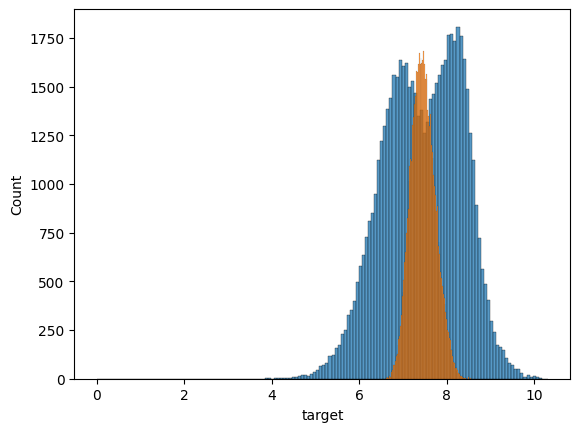

In [23]:
# 결과를 시각화 해봅니다.
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df_ans['target'])
sns.histplot(reg_lr_2.predict(df_test[X_cols_lr]))
plt.show()

In [28]:
# 두개를 합쳐 앙상블을 만듭니다. 앙상블 모델을 VotingRegressor입니다.
from sklearn.ensemble import VotingRegressor
reg_voting = VotingRegressor(
    [('lr1', reg_lr_1), 
     ('lr2', reg_lr_2)]
)
score_3 = cross_val_score(reg_voting, df_train[X_cols_lr], df_train['target'], cv=kf, scoring='neg_mean_squared_error')
score_3

array([-0.71062518, -0.71247679, -0.71785345, -0.70798244, -0.70276435])

In [29]:
-np.mean(score_3) #두 번째 모델 보다는 성능이 떨어 집니다.

0.7103404419718338

In [30]:
reg_voting = VotingRegressor(
    [('lr1', reg_lr_1), 
     ('lr2', reg_lr_2)]
)
reg_voting.fit(df_train[X_cols_lr], df_train['target'])

VotingRegressor(estimators=[('lr1',
                             Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(categorical_features=None,
                                                                                             categories=None,
                                                                                             drop='first',
                                                                                        

In [31]:
mean_squared_error(df_ans['target'], reg_voting.predict(df_test[X_cols_lr])) # 채점 결과도 좋지 않습니다.

0.7199369075761228

In [32]:
# 결과를 기록합니다.
pd.DataFrame({'target': reg_lr_2.predict(df_test[X_cols_lr])}, index=df_test.index).to_csv('answer6.csv')

# 3일간 고생하셨습니다. 좋은 결과 있기를 바랍니다!